In [ ]:
import pandas as pd
from google.colab import drive

# 1. 구글 드라이브 마운트 (승인 팝업이 뜨면 '허용'을 눌러주세요)
drive.mount('/content/drive')

# 2. 파일 경로 설정 (구글 드라이브 내 실제 파일 경로로 수정해주세요)
# 예: '/content/drive/MyDrive/폴더명/파일명.csv'
path1 = '/content/drive/MyDrive/251223/VIP_merged_result_columns_select_78cols.csv'
path2 = '/content/drive/MyDrive/251223/vip_final_churn_score_result_59364_9.csv'

# 3. 데이터 불러오기 (인코딩 처리 포함)
def load_csv(path):
    try:
        return pd.read_csv(path, encoding='utf-8-sig')
    except:
        return pd.read_csv(path, encoding='cp949')

df_usage = load_csv(path1)
df_balance = load_csv(path2)

# 4. 데이터 병합 (Merge)
# '발급회원번호'를 기준으로 옆으로(how='inner') 합칩니다.
# 만약 한 회원의 데이터가 여러 달(기준년월)로 나뉘어 있다면,
# on=['발급회원번호', '기준년월'] 처럼 두 개를 모두 써야 중복 데이터가 생기지 않습니다.
df= pd.merge(df_usage, df_balance, on=['발급회원번호', '기준년월'], how='inner')

# 5. 결과 확인
print(f"첫 번째 파일 크기: {df_usage.shape}")
print(f"두 번째 파일 크기: {df_balance.shape}")
print(f"병합 후 파일 크기: {df.shape}")
df.head()

# (선택 사항) 병합된 결과를 다시 구글 드라이브에 저장하고 싶을 때
# df_merged.to_csv('/content/drive/MyDrive/your_folder/merged_result.csv', index=False, encoding='utf-8-sig')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
첫 번째 파일 크기: (59364, 78)
두 번째 파일 크기: (59364, 9)
병합 후 파일 크기: (59364, 85)


,기준년월,발급회원번호,증감율_이용금액_신판_전월,증감율_이용금액_일시불_전월,증감율_이용건수_신용_분기,증감율_이용금액_신용_분기,증감율_이용금액_일시불_분기,잔액_신판평균한도소진율_r6m,잔액_신판최대한도소진율_r6m,잔액_신판ca평균한도소진율_r6m,...,최종유효년월_신용_이용가능,최종유효년월_신용_이용,최종카드발급경과월,Slope_Spend,Slope_Balance,Slope_Count,Risk_Flag,Churn_Score_Slope,Churn_Score_Total_Scaled,Final_Combined_Score
0,201807,SYN_100022,0.260559,0.260559,-0.116826,0.003011,0.003011,0.315508,0.410814,0.324979,...,201910.0,202001.0,47,0.0,0.0,0.0,0,0.0,0.155725,0.1
1,201808,SYN_100022,0.301082,0.301082,-0.387184,-0.303957,-0.303957,0.319732,0.402875,0.338338,...,202001.0,202001.0,48,40719.0,882129.0,-5.0,0,4.3,0.155756,2.2
2,201809,SYN_100022,0.234625,0.234625,-0.294737,-0.355487,-0.355487,0.371649,0.414520,0.405172,...,201910.0,201912.0,49,-5992.5,441733.0,-1.0,0,1.0,0.155745,0.6
3,201810,SYN_100022,0.276458,0.276458,-0.156311,-0.158050,-0.158050,0.349783,0.369626,0.387961,...,202003.0,202005.0,50,-28130.0,182261.0,0.5,0,0.6,0.155749,0.4
4,201811,SYN_100022,0.262132,0.262132,-0.098511,-0.038224,-0.038224,0.327325,0.363699,0.351894,...,202003.0,202005.0,51,47550.0,350593.0,2.5,0,0.0,0.155736,0.1


In [ ]:
X = df[['Final_Combined_Score']].values

In [ ]:
from sklearn.cluster import KMeans
# 클러스터 개수를 3개로 설정하고 모델 생성 (결과의 일관성을 위해 random_state 고정)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# 모델 학습 및 클러스터 예측 결과 추가
df['Cluster'] = kmeans.fit_predict(X)

# 각 클러스터에 몇 명의 고객이 배정되었는지 확인해볼까?
print(df['Cluster'].value_counts().sort_index())

Cluster
0    49194
1      390
2     9780
Name: count, dtype: int64


Text(0, 0.5, 'Final Combined Score')

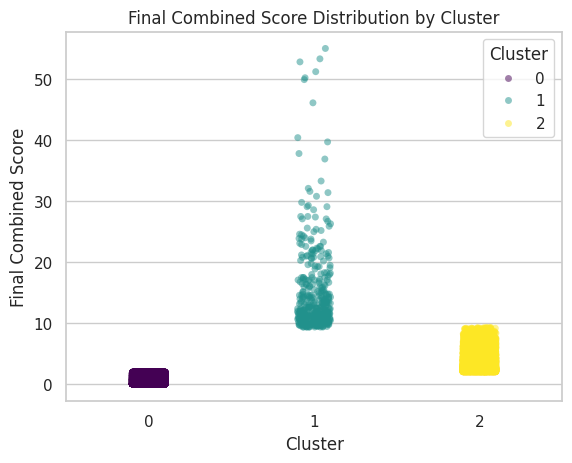

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set_theme(style="whitegrid")

# 클러스터별 점수 분포를 보기 위한 Strip Plot
sns.stripplot(x='Cluster', y='Final_Combined_Score', data=df, hue='Cluster', palette='viridis', jitter=True, alpha=0.5)

# 그래프 제목 및 라벨 설정
plt.title('Final Combined Score Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Final Combined Score')

# 그래프 저장
# plt.savefig('cluster_distribution.png')

In [ ]:
# Cluster 정보를 바탕으로 Target 변수 생성
# 0: 유지(Cluster 0), 1: 이탈 위험(Cluster 1, 2)
df['Target'] = df['Cluster'].map({0: 0, 1: 1, 2: 1})

# 잘 바뀌었는지 상위 데이터만 살짝 확인해볼까?
print(df[['Final_Combined_Score', 'Cluster', 'Target']].head())

   Final_Combined_Score  Cluster  Target
0                   0.1        0       0
1                   2.2        2       1
2                   0.6        0       0
3                   0.4        0       0
4                   0.1        0       0


In [ ]:
df['Target'].value_counts()

,count
Target,
0,49194
1,10170


In [ ]:
df.head()

,기준년월,발급회원번호,증감율_이용금액_신판_전월,증감율_이용금액_일시불_전월,증감율_이용건수_신용_분기,증감율_이용금액_신용_분기,증감율_이용금액_일시불_분기,잔액_신판평균한도소진율_r6m,잔액_신판최대한도소진율_r6m,잔액_신판ca평균한도소진율_r6m,...,최종카드발급경과월,Slope_Spend,Slope_Balance,Slope_Count,Risk_Flag,Churn_Score_Slope,Churn_Score_Total_Scaled,Final_Combined_Score,Cluster,Target
0,201807,SYN_100022,0.260559,0.260559,-0.116826,0.003011,0.003011,0.315508,0.410814,0.324979,...,47,0.0,0.0,0.0,0,0.0,0.155725,0.1,0,0
1,201808,SYN_100022,0.301082,0.301082,-0.387184,-0.303957,-0.303957,0.319732,0.402875,0.338338,...,48,40719.0,882129.0,-5.0,0,4.3,0.155756,2.2,2,1
2,201809,SYN_100022,0.234625,0.234625,-0.294737,-0.355487,-0.355487,0.371649,0.414520,0.405172,...,49,-5992.5,441733.0,-1.0,0,1.0,0.155745,0.6,0,0
3,201810,SYN_100022,0.276458,0.276458,-0.156311,-0.158050,-0.158050,0.349783,0.369626,0.387961,...,50,-28130.0,182261.0,0.5,0,0.6,0.155749,0.4,0,0
4,201811,SYN_100022,0.262132,0.262132,-0.098511,-0.038224,-0.038224,0.327325,0.363699,0.351894,...,51,47550.0,350593.0,2.5,0,0.0,0.155736,0.1,0,0


In [ ]:
# pip install LightGBM as lgb

In [ ]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import accuracy_score

In [ ]:

# ============================================================================
# 핵심 1: 불필요한 컬럼 정의
# ============================================================================
target_col = 'Target'  # 정답지
drop_cols = ['Slope_Spend','Slope_Balance','Slope_Count', '발급회원번호', '기준년월',
    'Risk_Flag','Churn_Score_Slope','Churn_Score_Total_Scaled','Final_Combined_Score','Cluster','Target'
    ]
# ============================================================================
# 핵심 2: 월별로 데이터 쪼개기 (Time Split)
# ============================================================================
# 1) 학습 데이터 (7, 8, 9, 10월)
train_df = df[df['기준년월'].isin([201807, 201808, 201809, 201810])]

# 2) 검증 데이터 (11월) - 모델 채점용
valid_df = df[df['기준년월'] == 201811]

# 3) 실전 예측 데이터 (12월) - 정답(Target)이 없는 미래 데이터
predict_df = df[df['기준년월'] == 201812]

# ============================================================================
# 핵심 3: X(문제), y(정답) 나누기
# ============================================================================
X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target_col]

X_predict = predict_df.drop(columns=drop_cols)
predict_ids = predict_df['발급회원번호'] # 결과 매칭용 ID 킵

# 문자열 -> category 변환 (LightGBM 최적화)
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')
        X_predict[col] = X_predict[col].astype('category')

# ============================================================================
# 핵심 4: 모델 학습
# ============================================================================
model = lgb.LGBMClassifier(n_estimators=1000, random_state=42, verbose=-1)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# ============================================================================
# 핵심 5: 12월 고객에 대한 이탈 확률 예측 및 결과 저장
# ============================================================================
pred_prob = model.predict_proba(X_predict)[:, 1]

# 결과 정리
final_result = pd.DataFrame({
    '발급회원번호': predict_ids,
    '이탈예측확률': pred_prob
})

# 결과 정리
final_result = pd.DataFrame({
    '발급회원번호': predict_ids,
    '이탈예측확률': pred_prob
})

print(final_result.sort_values('이탈예측확률', ascending=False).head(10))

# # 드라이브에 결과 저장 (CSV)
# final_result.to_csv(output_path, index=False, encoding='utf-8-sig')

# print(f"예측 결과가 다음 경로에 저장되었습니다: {output_path}")
# print(final_result.sort_values('이탈예측확률', ascending=False).head(10))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 0.31303
            발급회원번호    이탈예측확률
34487  SYN_2553493  0.972532
42521  SYN_2946466  0.962071
39035  SYN_2778092  0.957498
58727   SYN_970882  0.945460
19715  SYN_1896900  0.941898
19271  SYN_1880379  0.937359
50849   SYN_631608  0.923681
31253  SYN_2410781  0.922246
14747  SYN_1680282  0.921115
15161  SYN_1701118  0.919658


In [ ]:
pred_valid = model.predict(X_valid)
print("검증(11월) 정확도:", accuracy_score(y_valid, pred_valid))

검증(11월) 정확도: 0.8703254497675359


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 검증 데이터에 대한 예측값
y_pred = model.predict(X_valid)

# 상세 리포트 출력
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      8356
           1       0.70      0.29      0.41      1538

    accuracy                           0.87      9894
   macro avg       0.79      0.64      0.67      9894
weighted avg       0.85      0.87      0.85      9894



In [ ]:
# 1. 학습에 사용할 피처(X)와 정답(y) 분리
# ID성 컬럼과 점수/타겟 관련 컬럼은 제외합니다.
exclude_cols = ['발급회원번호', '기준년월', 'Target', 'Cluster', 'Final_Combined_Score',
                'Churn_Score_Slope', 'Churn_Score_Total_Scaled']

X = df.drop(columns=exclude_cols, errors='ignore')
y = df['Target']

print(f"원본 데이터 분포:\n{y.value_counts()}")

원본 데이터 분포:
Target
0    49194
1    10170
Name: count, dtype: int64


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# 언더샘플링 적용
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(f"언더샘플링 후 데이터 분포:\n{y_resampled.value_counts()}")

언더샘플링 후 데이터 분포:
Target
0    10170
1    10170
Name: count, dtype: int64


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import lightgbm as lgb

# 1. 기존 코드의 핵심 3번: X, y 나누기까지 진행
X_train_raw = train_df.drop(columns=drop_cols)
y_train_raw = train_df[target_col]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target_col]

# 2. [추가] 언더샘플링 적용 (학습 데이터에만!)
# 샘플링 전략을 'auto'로 하면 소수 클래스인 1에 맞춰 0의 개수를 줄입니다.
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_raw, y_train_raw)

print(f"샘플링 전 학습 데이터 (0, 1): {y_train_raw.value_counts().to_dict()}")
print(f"샘플링 후 학습 데이터 (0, 1): {y_train_rus.value_counts().to_dict()}")

# 3. 모델 학습 (핵심 4번)
# 샘플링된 X_train_rus, y_train_rus를 넣어서 학습시킵니다.
model = lgb.LGBMClassifier(n_estimators=1000, random_state=42, verbose=-1)

model.fit(
    X_train_rus, y_train_rus,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 4. 성능 확인 (Recall 점수 체크)
y_valid_pred = model.predict(X_valid)
print("\n--- 언더샘플링 적용 후 11월 검증 결과 ---")
print(classification_report(y_valid, y_valid_pred))

샘플링 전 학습 데이터 (0, 1): {0: 32429, 1: 7147}
샘플링 후 학습 데이터 (0, 1): {0: 7147, 1: 7147}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.512716

--- 언더샘플링 적용 후 11월 검증 결과 ---
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      8356
           1       0.35      0.78      0.48      1538

    accuracy                           0.74      9894
   macro avg       0.65      0.75      0.65      9894
weighted avg       0.85      0.74      0.77      9894



In [ ]:
# [핵심 4] 모델 학습 부분을 이렇게 수정해보세요

# 1. 현재 y_train(7~10월) 내의 0과 1 비율 계산
counts = y_train.value_counts()
# 0의 개수를 1의 개수로 나눈 값 (예: 32000 / 7000 = 약 4.57)
train_ratio = counts[0] / counts[1]

print(f"학습 데이터 내 클래스 비율: {train_ratio:.2f}")

# 2. 모델 정의 시 가중치 적용
model = lgb.LGBMClassifier(
    n_estimators=1000,
    random_state=42,
    verbose=-1,
    scale_pos_weight=train_ratio  # <-- 여기에 계산한 비율을 넣습니다!
)

# 3. 학습 시작
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

학습 데이터 내 클래스 비율: 4.54
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.432239


LGBMClassifier(n_estimators=1000, random_state=42,
               scale_pos_weight=np.float64(4.537428291590877), verbose=-1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. 검증 데이터(11월) 예측
y_pred = model.predict(X_valid)

# 2. 성적표 출력
print("--- 가중치(scale_pos_weight) 적용 후 11월 검증 결과 ---")
print(classification_report(y_valid, y_pred))

# 3. 혼동 행렬 확인 (실제 vs 예측)
conf_matrix = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

--- 가중치(scale_pos_weight) 적용 후 11월 검증 결과 ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      8356
           1       0.00      0.00      0.00      1538

    accuracy                           0.84      9894
   macro avg       0.42      0.50      0.46      9894
weighted avg       0.71      0.84      0.77      9894

Confusion Matrix:
[[8356    0]
 [1538    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# [핵심 4] 모델 학습 부분 수정
import lightgbm as lgb

# 1. 가중치를 더 공격적으로 설정 (기존 4.54 -> 10 정도로 대폭 상향)
# 모델이 1을 못 찾으면 10배로 혼나게 만드는 겁니다.
aggressive_ratio = 10

model = lgb.LGBMClassifier(
    n_estimators=2000,       # 충분히 학습하도록 늘림
    learning_rate=0.01,      # 아주 천천히, 꼼꼼하게 학습 (중요!)
    scale_pos_weight=aggressive_ratio,
    num_leaves=31,           # 모델의 복잡도 유지
    min_child_samples=20,    # 너무 적은 샘플로 잎사귀를 만들지 않게
    random_state=42,
    verbose=-1,
    boost_from_average=False # 불균형 데이터에서 가끔 도움이 됨
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='binary_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=100), # 좀 더 끈기 있게 기다려주기
        lgb.log_evaluation(period=10)            # 10번마다 학습 과정 출력
    ]
)

Training until validation scores don't improve for 100 rounds
[10]	valid_0's binary_logloss: 0.705122
[20]	valid_0's binary_logloss: 0.717929
[30]	valid_0's binary_logloss: 0.730058
[40]	valid_0's binary_logloss: 0.741633
[50]	valid_0's binary_logloss: 0.752797
[60]	valid_0's binary_logloss: 0.762737
[70]	valid_0's binary_logloss: 0.771031
[80]	valid_0's binary_logloss: 0.779649
[90]	valid_0's binary_logloss: 0.787957
[100]	valid_0's binary_logloss: 0.794977
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694331


LGBMClassifier(boost_from_average=False, learning_rate=0.01, n_estimators=2000,
               random_state=42, scale_pos_weight=10, verbose=-1)

In [ ]:
model = lgb.LGBMClassifier(random_state=42, verbose=-1) # 가중치 제거
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=50)])

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.323965


LGBMClassifier(random_state=42, verbose=-1)

In [ ]:
# # 1. 나눔 폰트 설치
# !apt-get -qq -y install fonts-nanum > /dev/null

# # 2. Matplotlib 캐시 삭제 (명령어 _rebuild 대신 이 방법을 씁니다)
# !rm -rf ~/.cache/matplotlib

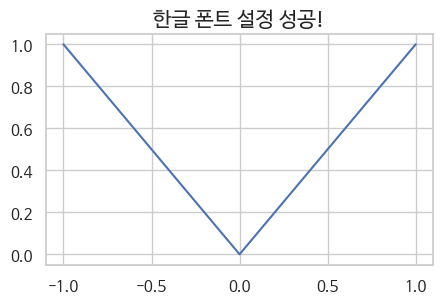

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 1. 폰트 설정 (나눔바른고딕)
plt.rc('font', family='NanumBarunGothic')

# 2. 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 3. 제대로 설정됐는지 확인
plt.figure(figsize=(5,3))
plt.title("한글 폰트 설정 성공!", fontsize=15)
plt.plot([-1, 0, 1], [1, 0, 1])
plt.show()

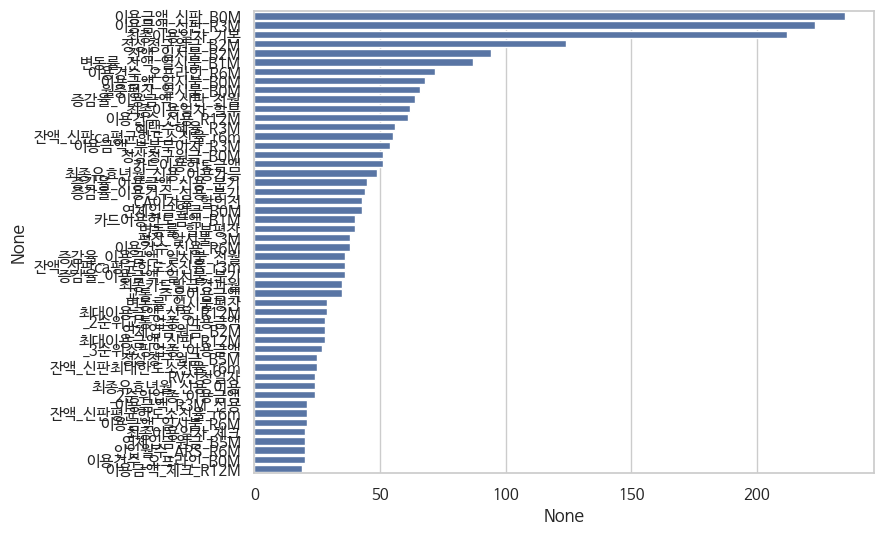

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False).head(50)

plt.figure(figsize=(8, 6))
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [ ]:
print(ftr_top20)

이용금액_신판_B0M           235
이용금액_신판_R3M           223
최종이용일자_기본             212
정상청구원금_B2M            124
잔액_일시불_B2M             94
변동률_잔액_일시불_B1M         87
이용건수_오프라인_R6M          72
이용금액_일시불_B0M           68
월중평잔_일시불_B0M           66
증감율_이용금액_신판_전월         64
최종이용일자_할부              62
이용건수_신용_R12M           61
혜택수혜율_R3M              56
잔액_신판ca평균한도소진율_r6m     55
이용금액_부분무이자_R3M         54
정상청구원금_B0M             51
카드이용한도금액               51
최종유효년월_신용_이용가능         49
증감율_이용금액_신용_분기         45
증감율_이용건수_신용_분기         44
CA이자율_할인전              43
연체입금원금_B0M             43
카드이용한도금액_B1M           40
변동률_할부평잔               40
평잔_일시불_3M              38
이용건수_신용_R6M            38
증감율_이용금액_일시불_전월        36
잔액_신판ca평균한도소진율_r3m     36
증감율_이용금액_일시불_분기        36
최종카드발급경과월              35
교통_주유이용금액              35
변동률_일시불평잔              29
최대이용금액_신용_R12M         29
_2순위교통업종_이용금액          28
연체입금원금_B2M             28
최대이용금액_신판_R12M         28
_3순위쇼핑업종_이용금액          27
정상청구원금_B5M             25
잔액_신판최대한도소진율

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# 1. 검증 데이터에 대한 이탈 확률(Probability) 예측
# predict() 대신 predict_proba()를 사용하여 0~1 사이의 확률값을 가져옵니다.
y_prob = model.predict_proba(X_valid)[:, 1]

# 2. 여러 임계값을 시도하며 점수 계산
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for thresh in thresholds:
    # 임계값보다 크면 1, 작으면 0으로 변환
    temp_pred = (y_prob >= thresh).astype(int)

    precision = precision_score(y_valid, temp_pred)
    recall = recall_score(y_valid, temp_pred)
    f1 = f1_score(y_valid, temp_pred)

    results.append({
        'Threshold': thresh,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    })

# 결과 출력
threshold_df = pd.DataFrame(results)
print(threshold_df)

   Threshold  Precision  Recall  F1-Score
0        0.1     0.2507  0.9291    0.3949
1        0.2     0.3914  0.7243    0.5082
2        0.3     0.5397  0.5436    0.5416
3        0.4     0.6452  0.3641    0.4655
4        0.5     0.7560  0.2237    0.3452
5        0.6     0.8596  0.1313    0.2279
6        0.7     0.9107  0.0663    0.1236
7        0.8     0.9524  0.0260    0.0506
8        0.9     1.0000  0.0052    0.0103


<Figure size 800x600 with 0 Axes>

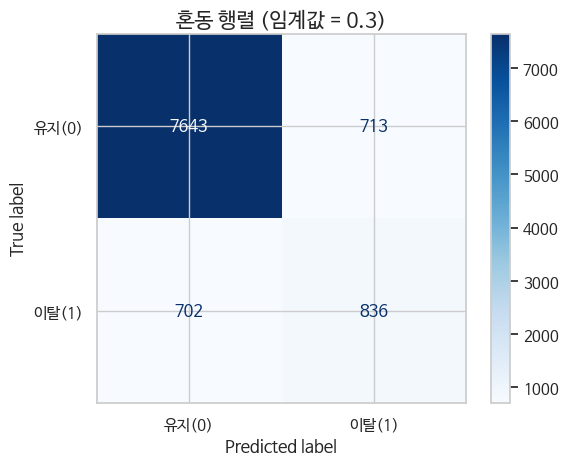


--- 임계값 0.3 적용 시 상세 성적표 ---
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      8356
           1       0.54      0.54      0.54      1538

    accuracy                           0.86      9894
   macro avg       0.73      0.73      0.73      9894
weighted avg       0.86      0.86      0.86      9894



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. 검증 데이터(11월)에 대한 이탈 확률 가져오기
y_prob_valid = model.predict_proba(X_valid)[:, 1]

# 2. 임계값 0.3 적용하여 최종 예측값(0 또는 1) 결정
best_threshold = 0.3
y_pred_03 = (y_prob_valid >= best_threshold).astype(int)

# 3. 혼동행렬 계산
cm = confusion_matrix(y_valid, y_pred_03)

# 4. 혼동행렬 시각화
plt.figure(figsize=(8, 6))
# 한글 폰트가 설정되어 있어야 라벨이 안 깨집니다.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['유지(0)', '이탈(1)'])
disp.plot(cmap='Blues', values_format='d') # 정수 형태로 표시
plt.title(f'혼동 행렬 (임계값 = {best_threshold})', fontsize=15)
plt.show()

# 5. 상세 성능 리포트 출력
print(f"\n--- 임계값 {best_threshold} 적용 시 상세 성적표 ---")
print(classification_report(y_valid, y_pred_03))